## Facial keypoints detection

In this task you will create facial keypoint detector based on CNN regressor.


![title](example.png)

### Load and preprocess data

Now you have to read `gt.csv` file and images from `images` dir. File `gt.csv` contains header and ground truth points for every image in `images` folder. It has 29 columns. First column is a filename and next 28 columns are `x` and `y` coordinates for 14 facepoints. We will make following preprocessing:
1. Scale all images to resolution $100 \times 100$ pixels.
2. Scale all coordinates to range $[-0.5; 0.5]$. To obtain that, divide all x's by width (or number of columns) of image, and divide all y's by height (or number of rows) of image and subtract 0.5 from all values.

Function `load_imgs_and_keypoint` should return a tuple of two numpy arrays: `imgs` of shape `(N, 100, 100, 3)`, where `N` is the number of images and `points` of shape `(N, 28)`.

In [9]:
### Useful routines for preparing data
from numpy import array, zeros
from os.path import join
from skimage.color import gray2rgb
from skimage.io import imread
from skimage.transform import resize
import pandas as pd
import cv2

def load_imgs_and_keypoints():
    # Write your code for loading images and points here
    data=pd.read_csv('data/gt.csv')
    
    #First get the images list 
    imgs=data['filename']
    
    #Drop filename column
    data=data.drop(columns=['filename'])
    points=data.values
    
    #Index tracker 
    itr=0
    
    #Processing image points
    images=[]
    pts=[]
    
    for each in imgs:
        #Process image
        img_path='data/images/'+each
        img_data=cv2.cvtColor(cv2.imread(img_path),cv2.COLOR_BGR2RGB)
        rows,col,_=img_data.shape
        img_data_nw=resize(img_data,(100,100))
        images.append(img_data_nw)       
    
        #Process points 
        intr_pts=[]
        for var in range(14):
            y=points[itr][2*var+1]/rows-0.5
            x=points[itr][2*var]/col-0.5
            intr_pts.append(x)
            intr_pts.append(y)
        pts.append(intr_pts)
                
        itr+=1
            
    images=array(images)
    points=array(points)
    
    return images,pts
        

imgs, points = load_imgs_and_keypoints()

[-0.3053435114503817,
 -0.3053435114503817,
 -0.01526717557251911,
 -0.27099236641221375,
 0.14503816793893132,
 -0.25190839694656486,
 0.2748091603053435,
 -0.3015267175572519,
 -0.24045801526717558,
 -0.20610687022900764,
 -0.17557251908396948,
 -0.2137404580152672,
 -0.08015267175572521,
 -0.18702290076335876,
 0.11068702290076338,
 -0.16793893129770993,
 0.15267175572519087,
 -0.1984732824427481,
 0.23664122137404575,
 -0.17938931297709926,
 0.09541984732824427,
 0.04961832061068705,
 -0.1488549618320611,
 0.16412213740458015,
 0.03435114503816794,
 0.1870229007633588,
 0.14122137404580148,
 0.18320610687022898]

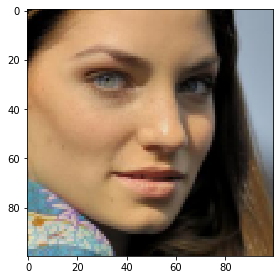

In [10]:
# Example of output
%matplotlib inline
from skimage.io import imshow
imshow(imgs[0])
points[0]

### Visualize data

Let's prepare a function to visualize points on image. Such function obtains two arguments: an image and a vector of points' coordinates and draws points on image (just like first image in this notebook).

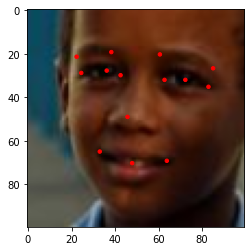

In [11]:
import matplotlib.pyplot as plt
# Circle may be useful for drawing points on face
# See matplotlib documentation for more info
from matplotlib.patches import Circle

def visualize_points(img, points):
    plt.figure()
    plt.imshow(img)
    cols,rows,_ = img.shape
    patches=[]
    r=0.8
    fig = plt.gcf()
    ax = fig.gca()
    for i in range(14):
        ax.add_artist((Circle(((points[2*i]+0.5)*cols, (points[2*i+1]+0.5)*rows), r, color='r')))
    
visualize_points(imgs[1], points[1])

### Train/val split

Run the following code to obtain train/validation split for training neural network.

In [12]:
from sklearn.model_selection import train_test_split
imgs_train, imgs_val, points_train, points_val = train_test_split(imgs, points, test_size=0.1)

### Simple data augmentation

For better training we will use simple data augmentation — flipping an image and points. Implement function flip_img which flips an image and its' points. Make sure that points are flipped correctly! For instance, points on right eye now should be points on left eye (i.e. you have to mirror coordinates and swap corresponding points on the left and right sides of the face). VIsualize an example of original and flipped image.

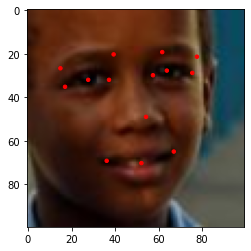

In [17]:
import numpy as np

def flip_img(img, points):
    points=np.array(points)
    img_flip = img[:, ::-1]
    points_flip = np.zeros(points.shape)
    flip_indices = [3,2,1,0,9,8,7,6,5,4,10,13,12,11]
    for i in range(14):
        points_flip[2*i] = -points[2*flip_indices[i]]
        points_flip[2*i+1] = points[2*flip_indices[i]+1]
    return img_flip, points_flip

f_img, f_points = flip_img(imgs[1], points[1])

visualize_points(f_img, f_points)

Time to augment our training sample. Apply flip to every image in training sample. As a result you should obtain two arrays: `aug_imgs_train` and `aug_points_train` which contain original images and points along with flipped ones.

In [18]:
aug_imgs_train = []
aug_points_train = []

for i in range(imgs_train.shape[0]):
    img_flip, points_flip = flip_img(imgs_train[i],points_train[i])
    aug_imgs_train.append(imgs_train[i])
    aug_imgs_train.append(img_flip)
    aug_points_train.append(points_train[i])
    aug_points_train.append(points_flip)

aug_imgs_train = np.array(aug_imgs_train)
aug_points_train = np.array(aug_points_train)

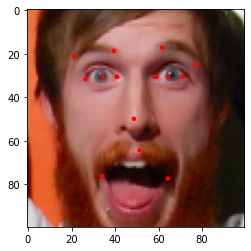

In [19]:
visualize_points(aug_imgs_train[2], aug_points_train[2])

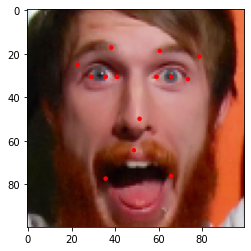

In [20]:
visualize_points(aug_imgs_train[3], aug_points_train[3])

### Network architecture and training

Now let's define neural network regressor. It will have 28 outputs, 2 numbers per point. The precise architecture is up to you. We recommend to add 2-3 (`Conv2D` + `MaxPooling2D`) pairs, then `Flatten` and 2-3 `Dense` layers. Don't forget about ReLU activations. We also recommend to add `Dropout` to every `Dense` layer (with p from 0.2 to 0.5) to prevent overfitting.


In [23]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.initializers import glorot_uniform

model = Sequential()

model.add(Conv2D(16, (3,3), input_shape=(100, 100, 3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding="same",kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  

model.add(Flatten())
model.add(Dense(128,kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.5)) 

model.add(Dense(64,kernel_initializer=glorot_uniform()))
model.add(LeakyReLU(alpha=0))

model.add(Dense(28,kernel_initializer=glorot_uniform()))

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 100, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50, 50, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)       

Time to train! Since we are training a regressor, make sure that you use mean squared error (mse) as loss. Feel free to experiment with optimization method (SGD, Adam, etc.) and its' parameters.

In [27]:
# ModelCheckpoint can be used for saving model during training.
# Saved models are useful for finetuning your model 
# See keras documentation for more info
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam

# Choose optimizer, compile model and run training
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mean_squared_error'])

BATCH_SIZE = 128
EPOCHS = 2


model.fit(
    aug_imgs_train, aug_points_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    verbose=1
)

Epoch 1/2
85/85 [==============================] - 32s 379ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 2/2
85/85 [==============================] - 32s 380ms/step - loss: 0.0018 - mean_squared_error: 0.0018


In [28]:
model.save_weights('my_model_weights.h5')

### Visualize results

Now visualize neural network results on several images from validation sample. Make sure that your network outputs different points for images (i.e. it doesn't output some constant).

In [29]:
val_points_pred = model.predict(imgs_val)

In [30]:
print(val_points_pred.shape)

(600, 28)


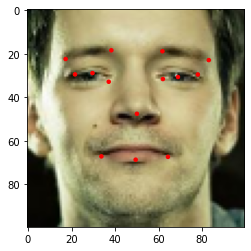

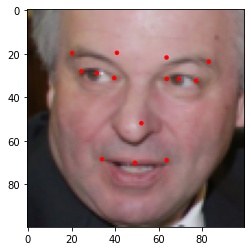

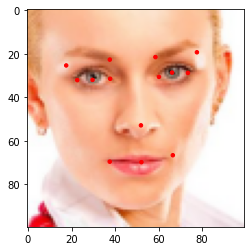

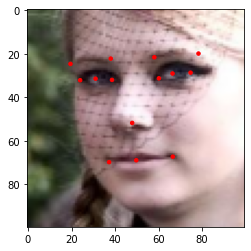

In [31]:
for i in range(11,15):
    visualize_points(imgs_val[i], val_points_pred[i])

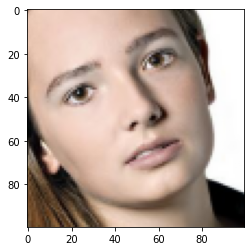

In [45]:
#Now taking sample image 
predict_img=cv2.cvtColor(cv2.imread('predict_sample.jpg'),cv2.COLOR_BGR2RGB)
#Transform to 100,100
predict_trans=resize(predict_img,(100,100))
#Display image 
plt.imshow(predict_trans)

(1, 28)


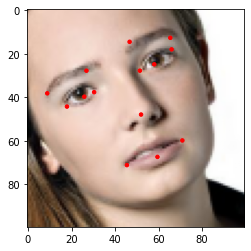

In [46]:
predict_trans_expanded=np.expand_dims(predict_trans,axis=0)
val_points_pred = model.predict(predict_trans_expanded)

print(val_points_pred.shape)

#Plot outcome
visualize_points(predict_trans, val_points_pred[0])